In [ ]:
# --- Model inputs (constant/mean-field intensities) ---
sigma = 0.
mu    = 0.1                       # log drift
lam   = [0, 0]               # \hat{\lambda}_1, \hat{\lambda}_2
eta   = [10.0, 10.0]                 # rates of exponential piece
delta = [0.1, 0.1]               # shifts (>=0)
y0    = 0.2                        # initial distance to barrier

# convenience
import numpy as np
import matplotlib.pyplot as plt

lam   = np.asarray(lam,   dtype=np.complex128)
eta   = np.asarray(eta,   dtype=np.complex128)
delta = np.asarray(delta, dtype=np.complex128)
a = np.complex128(mu - 0.5*sigma**2)   # a = mu - 1/2 sigma^2


In [6]:
import numpy as np

# --- parameters (as before) ---
sigma = float(sigma); a = np.complex128(mu - 0.5*sigma**2)
lam   = np.asarray(lam,   dtype=np.complex128)
eta   = np.asarray(eta,   dtype=np.complex128)
delta = np.asarray(delta, dtype=np.complex128)

def E_jump(k):            # E[e^{kZ}] = exp(-k delta) * eta/(eta+k)
    return np.exp(-k*delta) * (eta / (eta + k))

def dE_jump(k):           # d/dk of the above
    E = E_jump(k)
    return E * (-delta - 1.0/(eta + k))

def psi(k):               # Lévy/Laplace exponent
    return 0.5*(sigma**2)*k*k - a*k + np.sum(lam*(E_jump(k) - 1.0))

def dpsi(k):
    return (sigma**2)*k - a + np.sum(lam * dE_jump(k))

# -------- CORRECT real root: expand bracket until ψ(k_hi) >= q --------
def Phi_real(q, tol=1e-12, maxit=200):
    """Find the smallest nonnegative root k>=0 of psi(k)=q for real q>=0.
       Handles the 'no positive root' case by returning 0 when appropriate."""
    assert np.isrealobj(q) and q >= 0.0
    q = float(q)
    # special-case q=0: if psi never exceeds 0 (e.g., mu=sigma=0), the only root is k=0
    if q == 0.0:
        # check if psi grows positive for large k (happens when sigma>0)
        if np.real(psi(1.0)) <= 0 and np.real(psi(1e3)) <= 0:
            # likely no positive root -> hit prob = 1
            return np.complex128(0.0)
        # else fall through to regular bracketing

    # regular bracketing: expand until psi(k_hi) >= q
    k_lo = 0.0
    k_hi = 1.0
    # guard against NaNs around poles at k = -eta (negative): we only use k>=0
    for _ in range(200):
        val_hi = np.real(psi(k_hi))
        if val_hi >= q:
            break
        k_hi *= 2.0
    else:
        # still failed: if q==0 and psi never reaches 0+, return 0; otherwise fail
        if q == 0.0:
            return np.complex128(0.0)
        raise RuntimeError(f"Failed to bracket root for q={q}: psi({k_hi})={val_hi}")

    # bisection
    for _ in range(maxit):
        k_mid = 0.5*(k_lo + k_hi)
        val_mid = np.real(psi(k_mid))
        if abs(val_mid - q) < tol*(1 + q):
            return np.complex128(k_mid)
        if val_mid >= q:
            k_hi = k_mid
        else:
            k_lo = k_mid
    return np.complex128(k_mid)

def Phi(q, steps=6, newton_tol=1e-12, newton_max=30):
    """Complex continuation: start from the real-root Phi_real(Re q), then homotope Im q."""
    q = np.complex128(q)
    q0 = float(np.real(q))
    if q0 < 0.0:
        q0 = 0.0
    k = Phi_real(q0)  # returns 0 in the 'no positive root' case
    qi = float(np.imag(q))
    if qi == 0.0:
        return k
    # homotopy on imaginary part
    for t in np.linspace(0.0, 1.0, steps+1)[1:]:
        qt = q0 + 1j*(t*qi)
        for _ in range(newton_max):
            f  = psi(k) - qt
            df = dpsi(k)
            if df == 0: break
            k_new = k - f/df
            if np.real(k_new) <= 0:
                k_new = 1e-10 + 1j*np.imag(k_new)
            if abs(k_new - k) < newton_tol*(1 + abs(k)):
                k = k_new
                break
            k = k_new
    return k


# -------- LT, defective CF, Talbot CDF (unchanged) --------
def LT_phi(q, y):         # E[e^{-q τ}] = exp(-Φ(q) y)
    return np.exp(-Phi(q) * y)

def cf_defective(u, y):   # E[e^{i u τ} 1_{τ<∞}] = φ(-i u; y)
    u = np.asarray(u, dtype=np.complex128)
    out = np.empty_like(u, dtype=np.complex128)
    for idx, uu in enumerate(u.ravel()):
        out.flat[idx] = LT_phi(-1j*uu, y)
    return out.reshape(u.shape)

def talbot_nodes_weights(T, N=32):
    k = np.arange(1, N+1, dtype=float)
    theta = (k - 0.5) * np.pi / N
    z = theta/np.tan(theta) + 1j*theta
    dz_dtheta = -theta/(np.sin(theta)**2) + 1/np.tan(theta) + 1j
    s = (N/T) * z
    ds_dtheta = (N/T) * dz_dtheta
    dtheta = np.pi / N
    w = (np.exp(s*T) * ds_dtheta * dtheta) / (2j*np.pi)
    return s, w

def cdf_via_talbot(y, T_vals, N=48):
    T_vals = np.asarray(T_vals, float)
    F = np.zeros_like(T_vals, dtype=float)
    for j, T in enumerate(T_vals):
        s, w = talbot_nodes_weights(T, N=N)
        vals = np.array([LT_phi(sk, y)/sk for sk in s], dtype=np.complex128)
        Fj = np.real(np.sum(w * vals))
        F[j] = 0.0 if Fj < 0 else (1.0 if Fj > 1 else Fj)
    return F


In [3]:
# for qtest in [0.01, 0.1, 1.0]:
#     print("Φ(", qtest, ") =", Phi_real(qtest))

# LTV = 0.9
# y0 = np.log(1/LTV)
# print("CF_def(u=0) = hit prob =", cf_defective(0.0, y0).real)

# T_vals = np.linspace(0.001/365, 2/365, 48)

# # Defective CF samples
# for LTV in [0.9, 0.95, 0.99, .995]:
#     y0 = np.log(1/LTV)
#     # CDF via Talbot
#     F = cdf_via_talbot(y0, T_vals, N=46)
#     plt.plot(T_vals, F, label=LTV)
    
# plt.legend()
# # print("CDF samples:", list(zip(T_vals, F)))

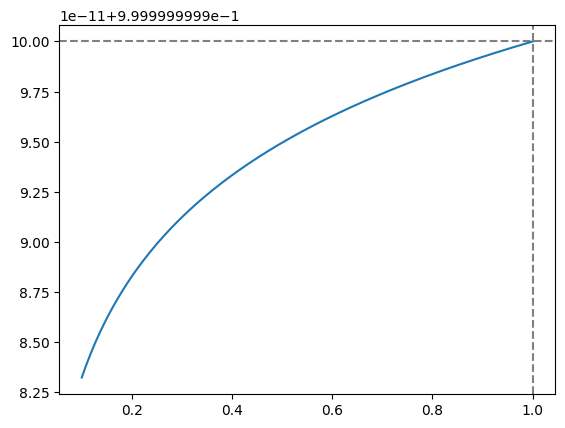

In [7]:
cf_vals = []
LTVs = np.linspace(.1,1, 200)
# Defective CF samples
for LTV in LTVs:
    y0 = np.log(1/LTV)
    cf_val= cf_defective(0, y0).real
    cf_vals.append(cf_val)
    
plt.axhline(1, color='gray', linestyle='--')    
plt.axvline(1, color='gray', linestyle='--')      

plt.plot(LTVs, cf_vals)

In [9]:
cf_vals

[array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 arr